In [38]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import seaborn as sns
import random
import cv2



In [39]:
data=pd.read_csv("../data/HAM10000_metadata.csv")

In [40]:
data.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [41]:
data=data.dropna()

In [42]:
data.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [43]:
print(data['dx'].value_counts())

dx
nv       6660
mel      1111
bkl      1089
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [44]:
df=data[["image_id","dx"]]

In [45]:
import os

IMAGE_DIR = "../data/raw"

df['image_path'] = df['image_id'].apply(
    lambda x: os.path.join(IMAGE_DIR, x + ".jpg")
)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13056\1895058411.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image_path'] = df['image_id'].apply(


In [46]:
df[['image_id', 'image_path']].head()


,image_id,image_path
0,ISIC_0027419,../data/raw\ISIC_0027419.jpg
1,ISIC_0025030,../data/raw\ISIC_0025030.jpg
2,ISIC_0026769,../data/raw\ISIC_0026769.jpg
3,ISIC_0025661,../data/raw\ISIC_0025661.jpg
4,ISIC_0031633,../data/raw\ISIC_0031633.jpg


In [47]:
img_path = df.iloc[0]['image_path']
img = cv2.imread(img_path)

print(img_path)
print(img is None)

../data/raw\ISIC_0027419.jpg
False


In [48]:
DATA_DIR = "../data/raw"

classes = sorted(df['dx'].unique())

print("Classes:", classes)
print("Number of classes:", len(classes))


Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Number of classes: 7


In [49]:
df_count = (
    df['dx']
    .value_counts()
    .reset_index()
)

df_count.columns = ['class', 'count']
df_count


,class,count
0,nv,6660
1,mel,1111
2,bkl,1089
3,bcc,514
4,akiec,327
5,vasc,142
6,df,115


Bisa terlihat disini bahwa classnya tidak balance, akan di balance dengan oversampling + undersampling ke angka 514. Angka ini dipilih karena menjadi titik tengah antar image yang lain, dimana datanya tidak terlalu sedikit namun tidak terlalu banyak. undersampling akan dilakukan untuk class nv, mel, dan bkl, sedangkan oversampling menggunakan SMOTE akan dilakukan di akiec, vasc, dan df. 

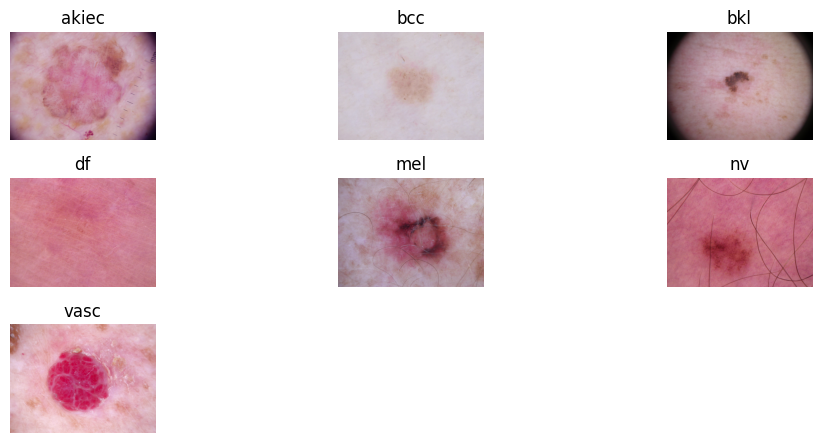

In [50]:
plt.figure(figsize=(10, 6))

for i, cls in enumerate(classes):
    # ambil 1 baris random untuk kelas ini
    sample = df[df['dx'] == cls].sample(1).iloc[0]

    img_path = sample['image_path']
    img = Image.open(img_path)

    plt.subplot(4, 3, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()


Bisa terlihat disini bahwa setiap class disini memiliki keunikan masing-masing, dimana terdapat perbedaan warna dan shape dari lesionnya. Oleh karena itu, penting untuk bisa mengambil fitur berupa shape, tekstur, dan warna dari data pada feature extractionnya. Selain itu, bisa terlihat juga bahwa terdapat rambut di beberapa gambar, sehingga diperlukan untuk di remove saat preprocessing menggunakan algoritma DullRazor.

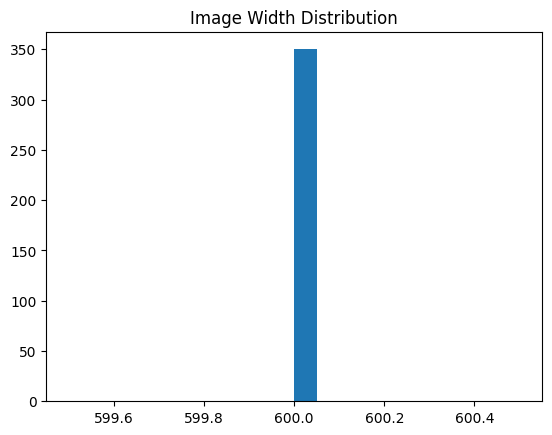

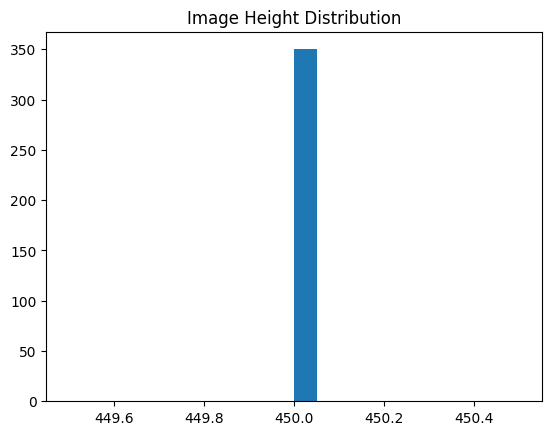

In [51]:
widths, heights = [], []

for cls in classes:
    subset = df[df['dx'] == cls].head(50)   # ambil max 50 per kelas

    for img_path in subset['image_path']:
        try:
            img = Image.open(img_path)
            w, h = img.size
            widths.append(w)
            heights.append(h)
        except:
            continue

plt.figure()
plt.hist(widths, bins=20)
plt.title("Image Width Distribution")
plt.show()

plt.figure()
plt.hist(heights, bins=20)
plt.title("Image Height Distribution")
plt.show()

Bisa terlihat disini bahwa size setiap imagenya sudah sama, sehingga nanti tinggal di resize saja ke 224x224 untuk menyesuaikan model, namun resize dengan padding, tidak di stretch supaya shape dari lesionnya tidak berubah.

In [52]:
modes = []

for cls in classes:
    subset = df[df['dx'] == cls].head(1000)  

    for img_path in subset['image_path']:
        try:
            img = Image.open(img_path)
            modes.append(img.mode)
        except:
            continue

print(Counter(modes))


Counter({'RGB': 4098})


Bisa dilihat disini bahwa setiap imagenya sudah berupa RGB, tidak ada perbedaan jenis color modenya.

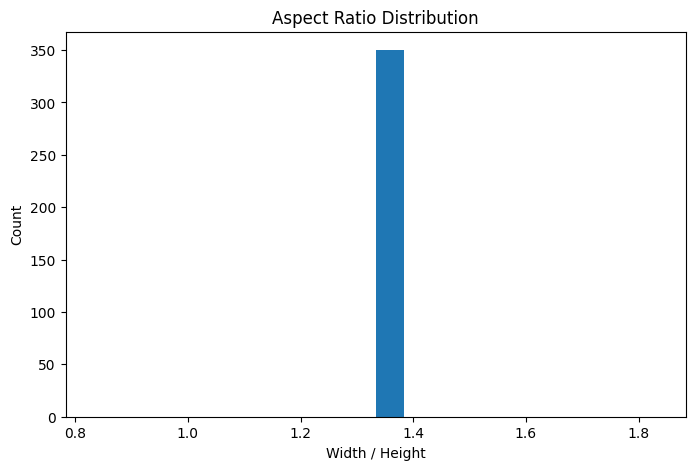

In [53]:
widths, heights = [], []

for cls in classes:
    subset = df[df['dx'] == cls].sample(
        min(50, len(df[df['dx'] == cls]))
    )

    for img_path in subset['image_path']:
        try:
            img = Image.open(img_path)
            w, h = img.size
            widths.append(w)
            heights.append(h)
        except:
            continue

aspect_ratios = [w/h for w, h in zip(widths, heights)]

plt.figure(figsize=(8, 5))
plt.hist(aspect_ratios, bins=20)
plt.title("Aspect Ratio Distribution")
plt.xlabel("Width / Height")
plt.ylabel("Count")
plt.show()


Dari sini bisa dilihat bahwa setiap image memiliki aspect ratio yang sama, namun bukan di angka 1. Ketika di resize menjadi 224x224, nanti akan ditambahkan padding supaya image-nya tidak terjadi stretching.

In [54]:
corrupt = []

for cls in classes:

    subset = df[df['dx'] == cls]

    for img_path in subset['image_path']:
        try:
            Image.open(img_path)
        except:
            corrupt.append((cls, img_path))

print("Jumlah image corrupt:", len(corrupt))


Jumlah image corrupt: 0


tidak ada image yang corrupt. aman.

### Conclusion

* Lakukan oversampling + undersampling pada data.
* Lakukan resize menjadi 224x224 dengan padding supaya tidak terjadi stretch pada gambar.
* Tambahkan algoritma Dullrazor di preprocessing untuk menghapus rambut.
* Ambil fitur warna, tekstur, dan shape untuk memaksimalkan feature extraction.
* Color mode sudah berupa RGB semua, sehingga tidak perlu diubah. namun untuk kestabilan bisa juga ditambahkan pada code.